# 🧪 Evaluating the Fine-Tuned LLaMA 3.1 8B (Quantized)  

### ✅ Tasks  
- 📂 **Load the tokenizer** and **fine-tuned base model**  
- 🧩 **Load the PEFT adapter** for the fine-tuned weights  
- 🎯 **Run evaluation** — the moment of truth!  

In [ ]:
%pip install -q  peft torch bitsandbytes transformers matplotlib datasets

In [ ]:
# imports

import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from datasets import load_dataset
from google.colab import userdata
from huggingface_hub import login
from peft import PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    set_seed,
)

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential=True)

In [ ]:
# Log in to HuggingFace

hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential=True)

## 📥 Load Dataset

In [ ]:
%pip install -U datasets

In [ ]:
DATASET_NAME = "srajal87/pricer-data"
dataset = load_dataset(DATASET_NAME)
train = dataset["train"]
test = dataset["test"]

In [ ]:
test[0]

In [ ]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red": RED, "orange": YELLOW, "green": GREEN}


class Tester:
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error < 40 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error**2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        # print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color="deepskyblue", lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel("Ground Truth")
        plt.ylabel("Model Estimate")
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)

        # Add color legend
        from matplotlib.lines import Line2D

        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Accurate (green)",
                markerfacecolor="green",
                markersize=8,
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Medium error (orange)",
                markerfacecolor="orange",
                markersize=8,
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="High error (red)",
                markerfacecolor="red",
                markersize=8,
            ),
        ]
        plt.legend(handles=legend_elements, loc="upper right")

        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits / self.size * 100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

## 📥 Load Tokenizer and Model
The fine-tuned model (PeftModel) only holds the LoRA adapters, so it requires the base model to apply them correctly.

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Reduce the precision to 4 bits
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
)

# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

## 🧪 Load and Evaluate the Fine-Tuned Model with PEFT Adapters
10K Sample Fine-Tuned Model

In [ ]:
FINETUNED_MODEL = "srajal87/llama3-pricer-2025-08-12_17.41.59-size8000"
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")
fine_tuned_model

In [ ]:
top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [ ]:
improved_model_predict(test[0]["text"], device="cuda")

In [ ]:
Tester.test(improved_model_predict, test)

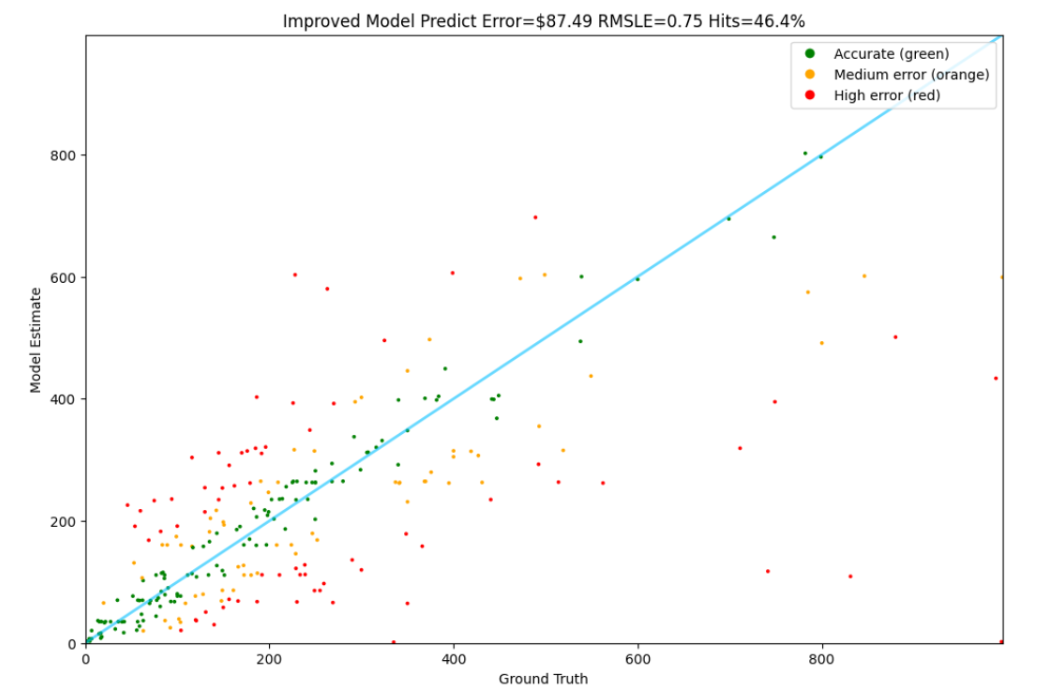

## 400K Sample Fine-Tuned Model

In [ ]:
FINETUNED_MODEL = "ed-donner/pricer-2024-09-13_13.04.39"
REVISION = "e8d637df551603dc86cd7a1598a8f44af4d7ae36"
fine_tuned_model = PeftModel.from_pretrained(
    base_model, FINETUNED_MODEL, revision=REVISION
)
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")
fine_tuned_model

In [ ]:
Tester.test(improved_model_predict, test)

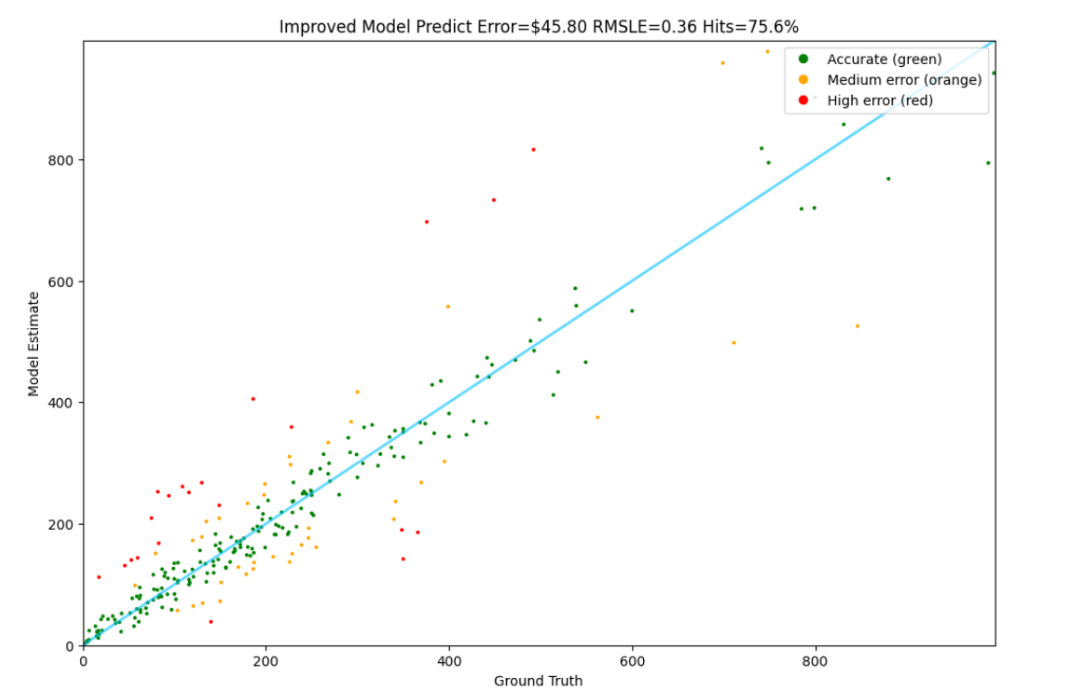